# Preparation

## Imports & functions definition

In [1]:
repo_path <- ".."

In [2]:
# Required packages
library("data.table")
library("DALEX")
library("DALEXtra")
library("ggplot2")
library("gridExtra")
library("pipeR")

# Jupyter settings
options(repr.plot.width = 22)
options(repr.plot.height = 8)
options(jupyter.rich_display = FALSE)
options(width = 120)

# Paths within the repo
data_path <- file.path(repo_path, "data/survival-data-split")
model_path <- file.path(repo_path, "models/pickles/opt_XGBTRegressor.pickle")

Welcome to DALEX (version: 1.2.0).
Find examples and detailed introduction at: https://pbiecek.github.io/ema/


Anaconda not found on your computer. Conda related functionality such as create_env.R and condaenv and yml parameters from explain_scikitlearn will not be available



In [3]:
# Function reads split data into a list.
read_data <- function(data_dir, extract_treatment = FALSE, ...) {
    data_names <- c("X_test", "X_train","y_test", "y_train")
    file_names <- sprintf("survival_%s.csv", data_names)
    paths <- file.path(data_dir, file_names)
    
    res <- setNames(lapply(paths, fread), data_names)
    if (!extract_treatment) return(res)
    
    extract_treatment(res, ...)
}


# Function separates treatment from the Xes.
extract_treatment <- function(data, idx = ncol(data$X_train)) {
    data <- lapply(data, as.data.frame)
    
    data$treatment_train <- data$X_train[, idx]
    data$X_train <- data$X_train[, -idx]
    
    data$treatment_test <- data$X_test[, idx]
    data$X_test <- data$X_test[, -idx]
    
    lapply(data, as.data.table)
}


# Function adjusts font size and fixes plot title for the DALEX plots to look cleanly in Jupyter Notebook.
fix_plot <- function(g, adjust_title_margin = FALSE, plot_title = NULL, font_size = 20) {
    g <- g + theme(
        axis.text = element_text(size = font_size),
        axis.title = element_text(size = font_size + 3),
        strip.text = element_text(size = font_size - 3, margin = margin(0, 0, 5, 0)),
        plot.subtitle = element_text(size = font_size - 2, margin = margin(-10, 0, 15, 0)),
        plot.title = element_text(size = font_size + 1),
        legend.title = element_text(size = font_size - 3),
        legend.text = element_text(size = font_size - 5)
    )
    
    if (adjust_title_margin) {
        g <- g + theme(plot.subtitle = element_text(margin = margin(0, 0, 5, 0)))
    }
    
    if (!is.null(plot_title)) {
        g <- g + ggtitle(plot_title)
    }
    
    g
}

## Reading the data

In [4]:
data <- read_data(data_path, TRUE)
X <- list(data$X_train, data$X_test) %>>% rbindlist() %>>% as.data.frame()
y <- list(data$y_train, data$y_test) %>>% rbindlist() %>>% as.data.frame()

## Creating explainers (one for each treatment variant)

In [5]:
explainer_Lev <- explain_scikitlearn(
    model_path,
    data = X,
    y = y,
    label = "XGBTRegressor Lev",
    predict_function = function(model, data, ...) yhat(model, data)[, 1],
    verbose = FALSE
)

explainer_Lev5FU <- explain_scikitlearn(
    model_path,
    data = X,
    y = y,
    label = "XGBTRegressor Lev+5FU",
    predict_function = function(model, data, ...) yhat(model, data)[, 2],
    verbose = FALSE
)

# Explainations

In [6]:
pdp_Lev <- model_profile(explainer_Lev)
pdp_Lev5FU <- model_profile(explainer_Lev5FU)

explained_vars <- c("age", "nodes")

### Average

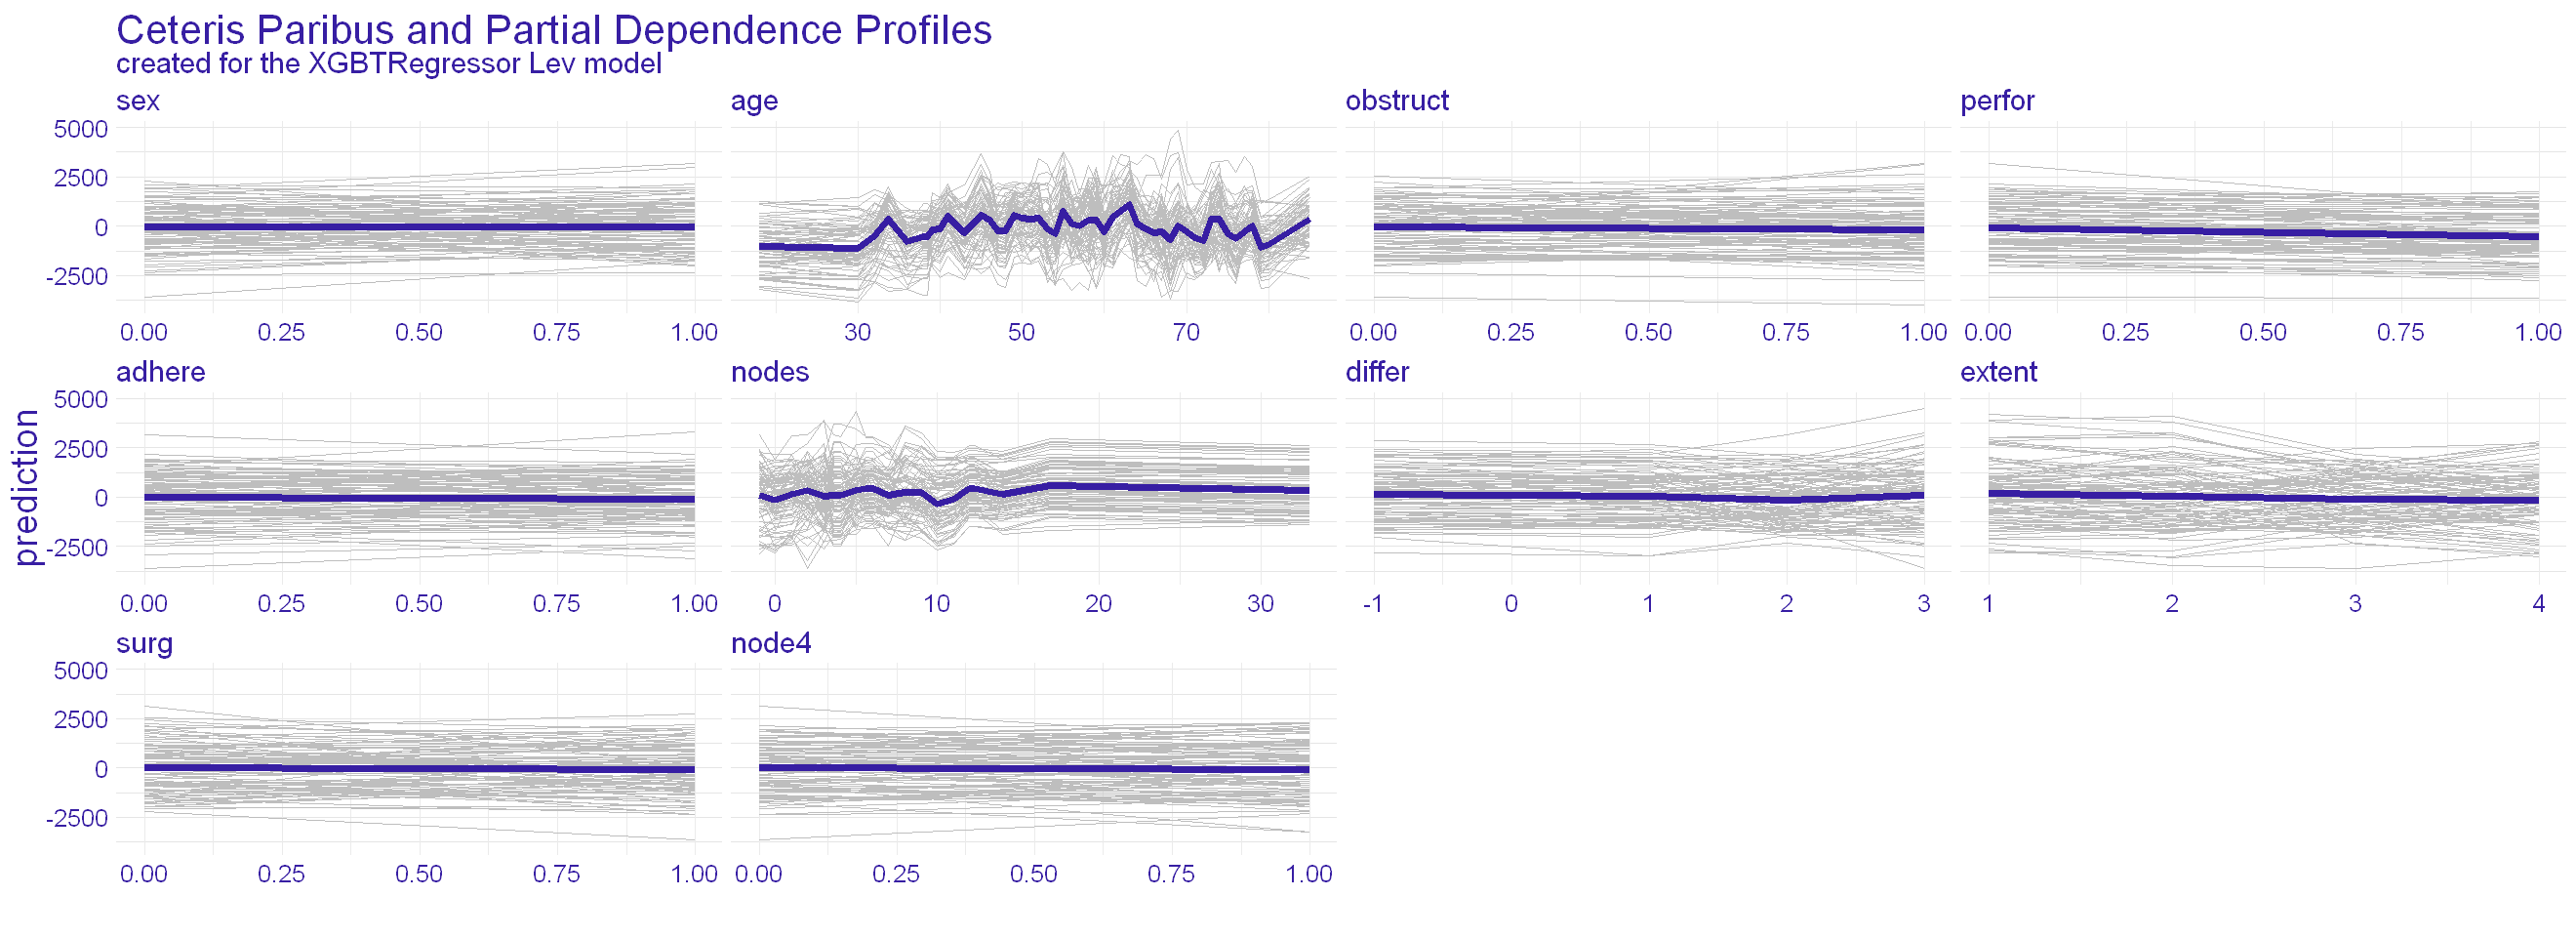

In [7]:
plot_pdp_Lev <- pdp_Lev %>>% plot(geom="profiles") %>>% fix_plot(adjust_title_margin = TRUE) %>>% `+`(
    theme(
        strip.text = element_text(size = 18),
        plot.title = element_text(size = 25),
        axis.text = element_text(size = 15)
    )
) %>>% `+` (
    ggtitle("Ceteris Paribus and Partial Dependence Profiles")
)

plot_pdp_Lev

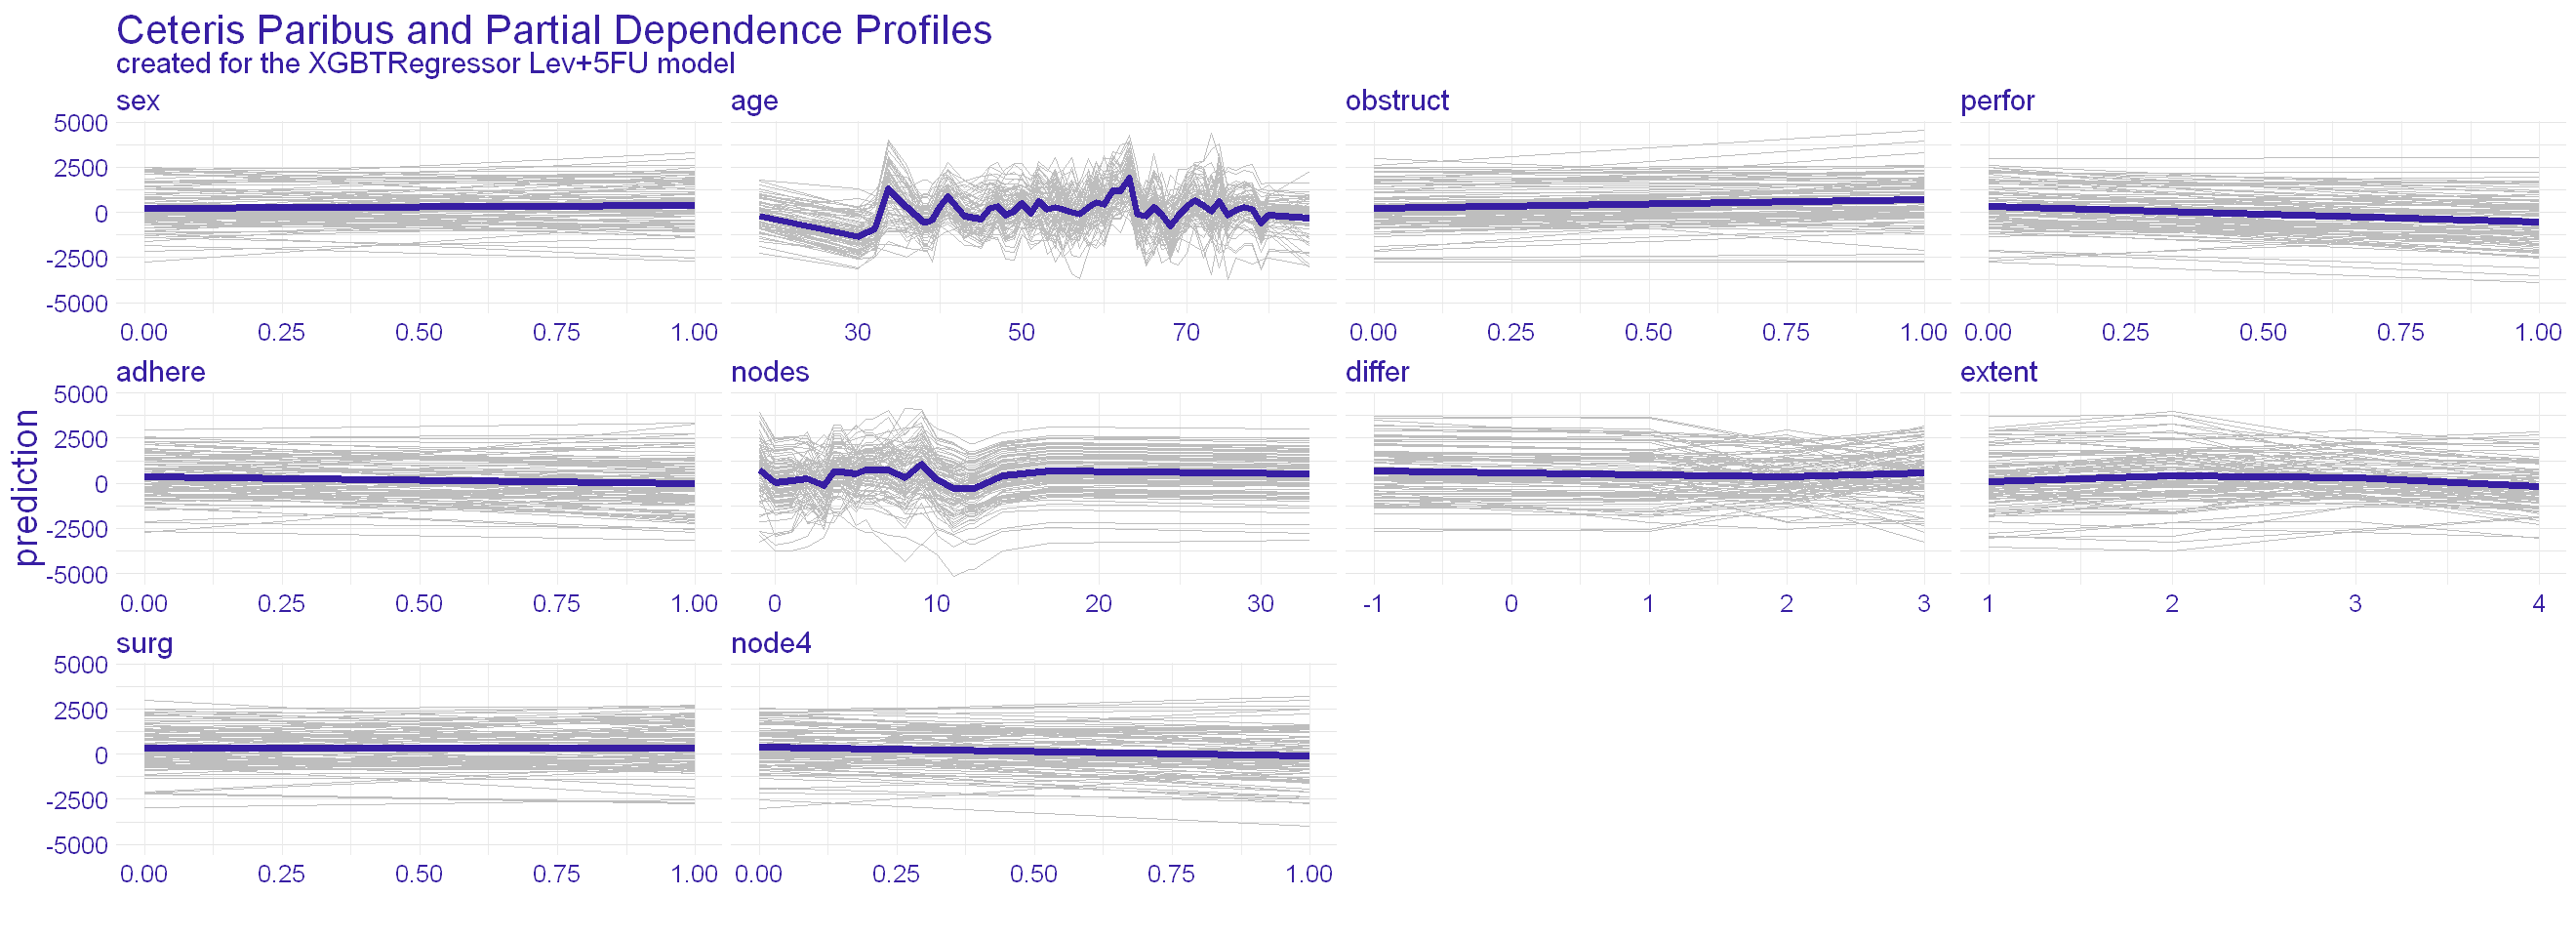

In [8]:
plot_pdp_Lev5FU <- pdp_Lev5FU %>>% plot(geom="profiles") %>>% fix_plot(adjust_title_margin = TRUE) %>>% `+`(
    theme(
        strip.text = element_text(size = 18),
        plot.title = element_text(size = 25),
        axis.text = element_text(size = 15)
    )
) %>>% `+` (
    ggtitle("Ceteris Paribus and Partial Dependence Profiles")
)

plot_pdp_Lev5FU

In [9]:
ggsave("../images/04-UL-PDP-Lev.png", plot_pdp_Lev, width = 6.67 * 2)
ggsave("../images/04-UL-PDP-Lev5FU.png", plot_pdp_Lev5FU, width = 6.67 * 2)

Saving 13.3 x 6.67 in image

Saving 13.3 x 6.67 in image



### Clustered

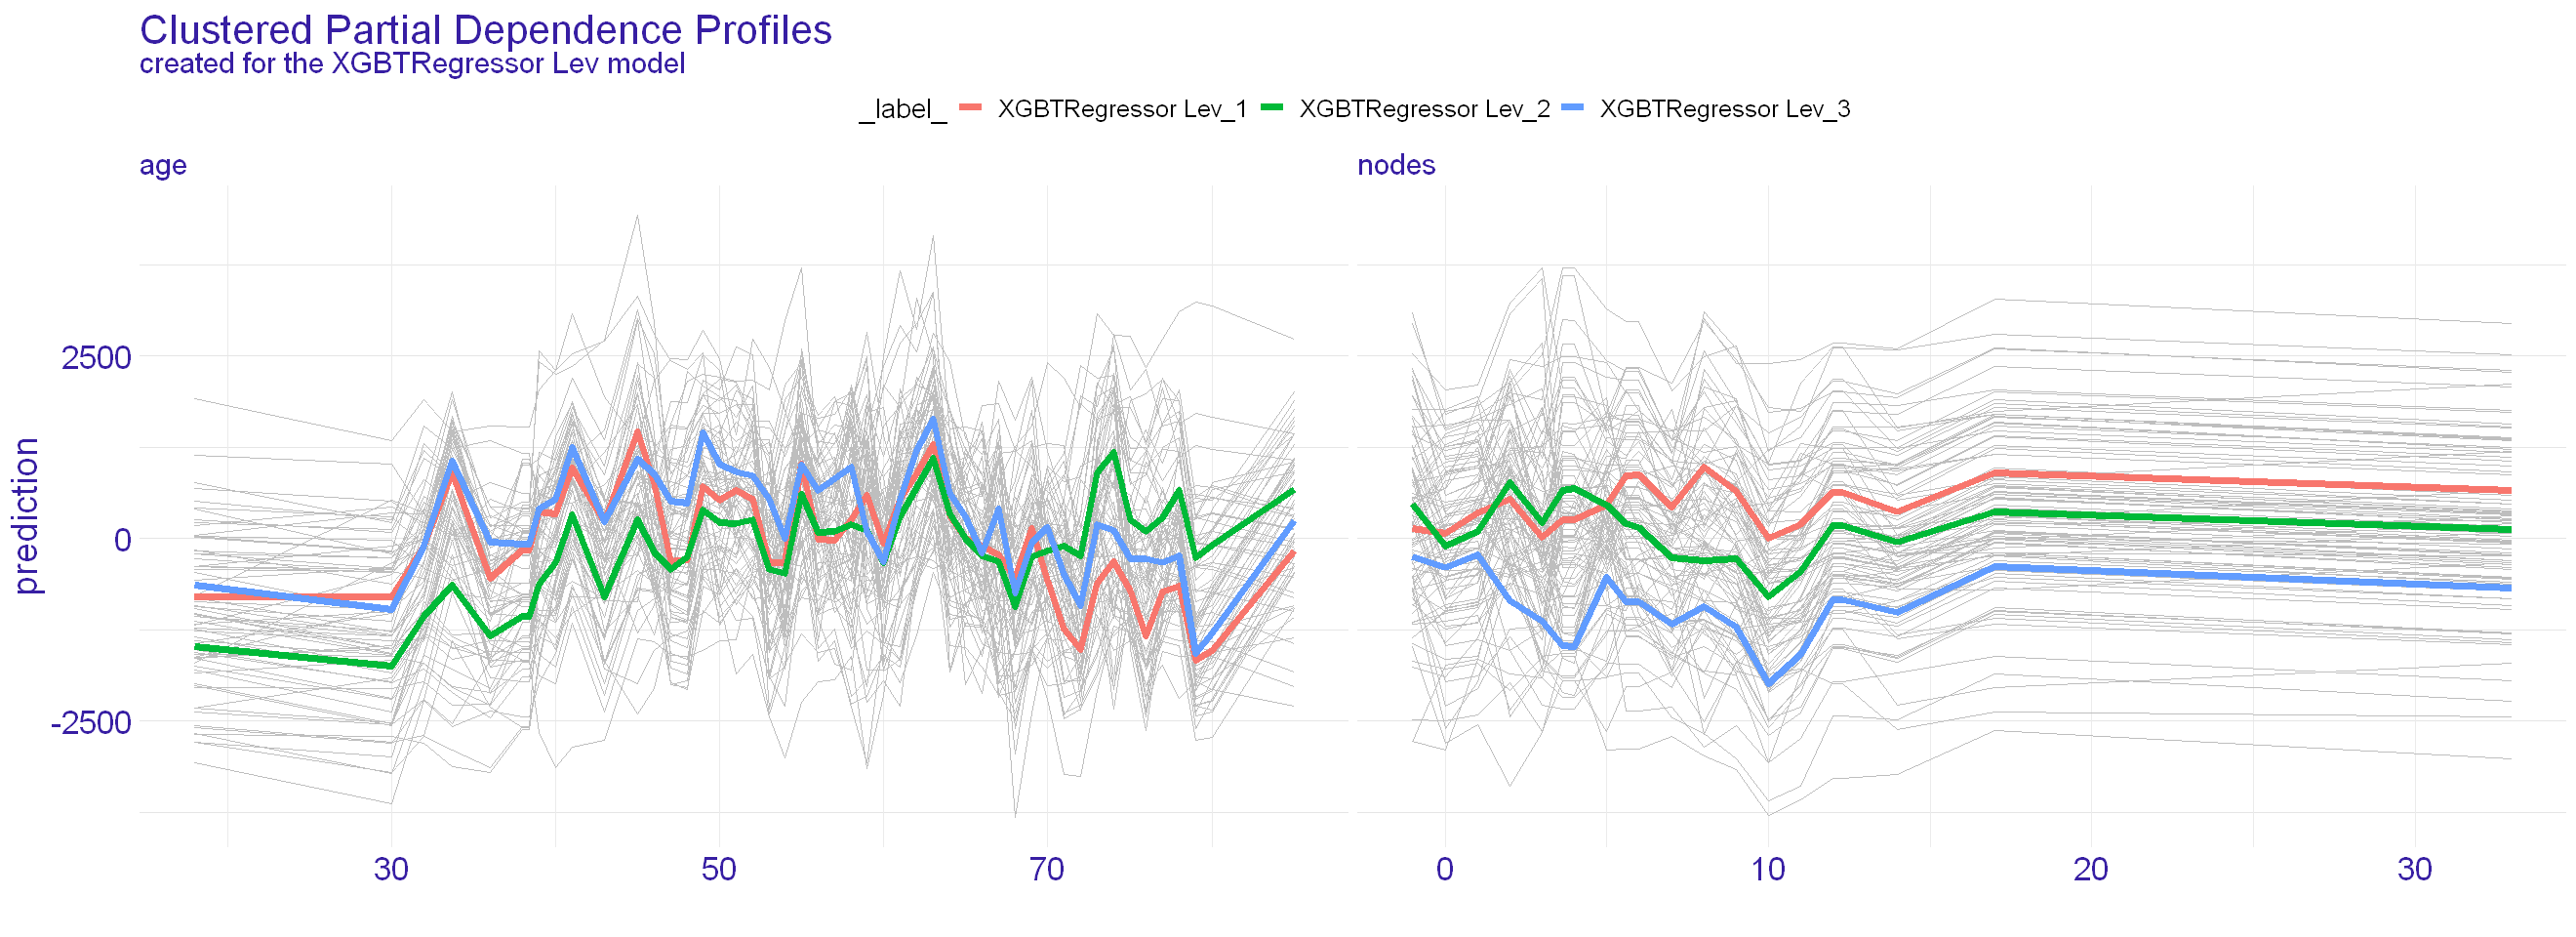

In [10]:
plot_clustered_Lev <- explainer_Lev %>>% model_profile(explained_vars, k = 3) %>>% plot(geom="profiles") %>>%
    fix_plot(adjust_title_margin = TRUE) %>>% `+`(ggtitle("Clustered Partial Dependence Profiles")) %>>% `+`(
        theme(
            strip.text = element_text(size = 18),
            plot.title = element_text(size = 25)
        )
    )

plot_clustered_Lev

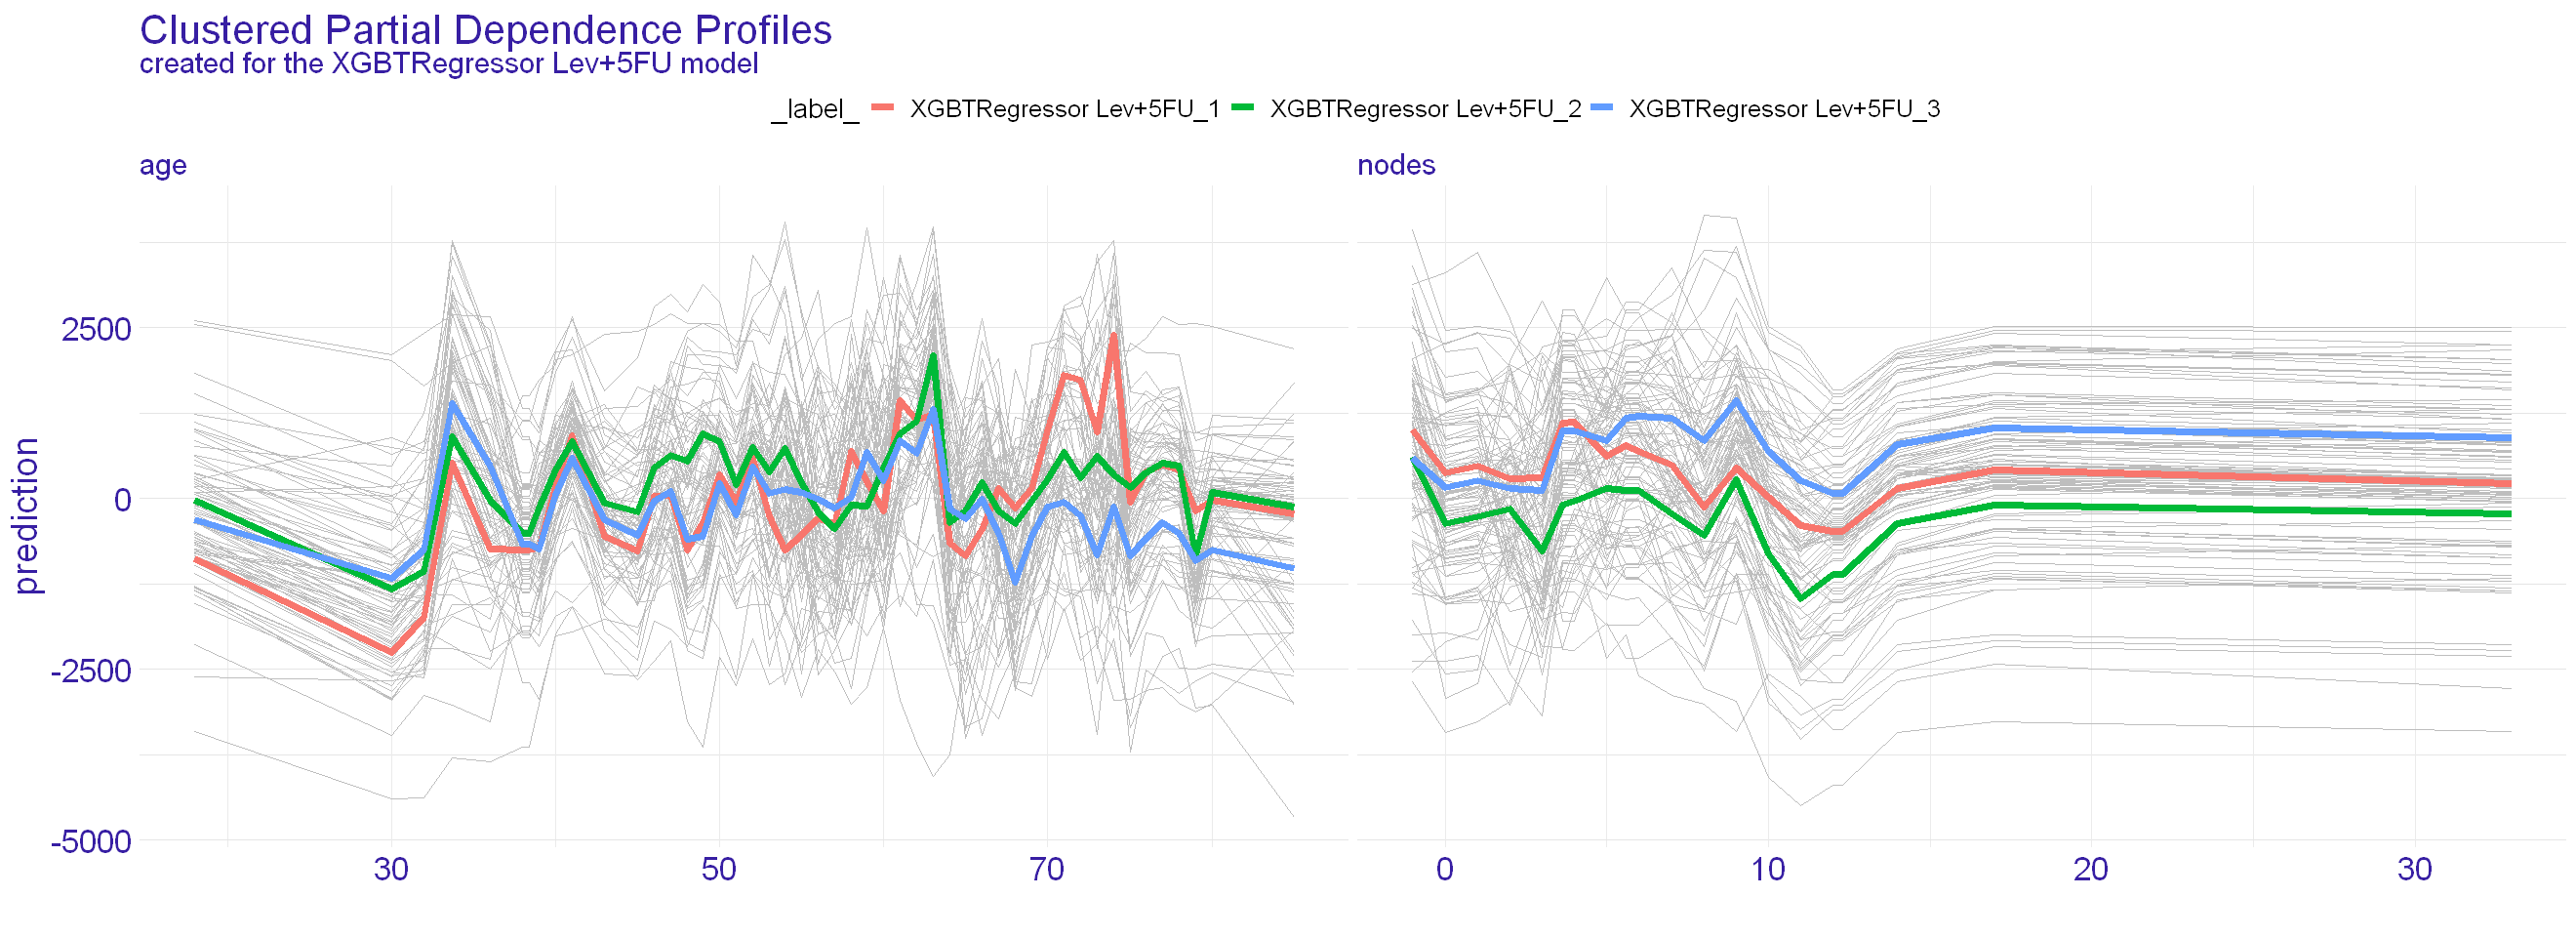

In [11]:
plot_clustered_Lev5FU <- explainer_Lev5FU %>>% model_profile(explained_vars, k = 3) %>>% plot(geom="profiles") %>>%
    fix_plot(adjust_title_margin = TRUE) %>>% `+`(ggtitle("Clustered Partial Dependence Profiles")) %>>% `+`(
        theme(
            strip.text = element_text(size = 18),
            plot.title = element_text(size = 25)
        )
    )

plot_clustered_Lev5FU

In [12]:
ggsave("../images/04-UL-PDP-Clustered-Lev.png", plot_clustered_Lev, width = 6.67 * 2)
ggsave("../images/04-UL-PDP-Clustered-Lev5FU.png", plot_clustered_Lev5FU, width = 6.67 * 2)

Saving 13.3 x 6.67 in image

Saving 13.3 x 6.67 in image



### Grouped

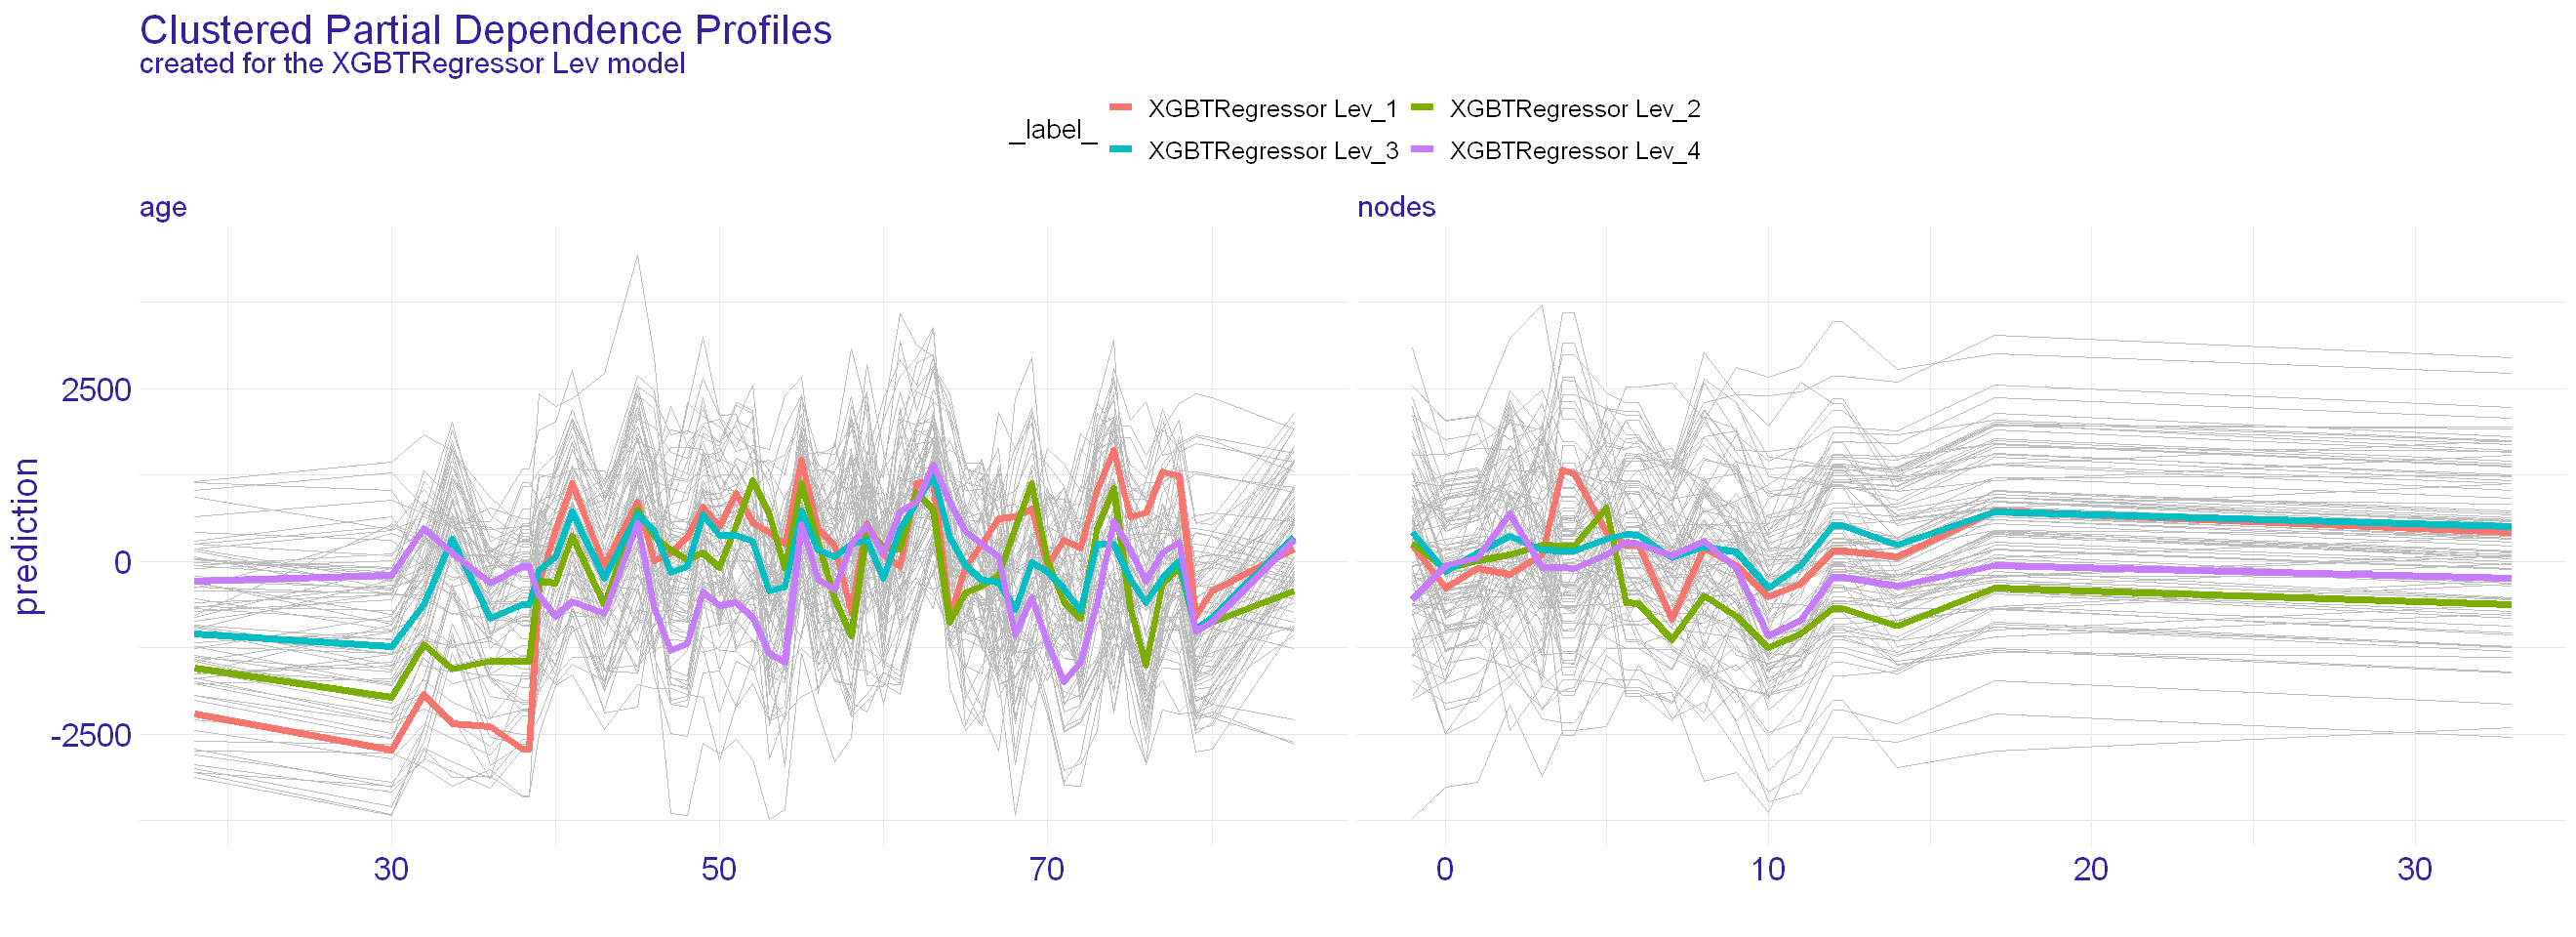

In [13]:
plot_grouped_Lev <- explainer_Lev %>>% model_profile(explained_vars, groups = "extent") %>>% plot(geom="profiles") %>>%
    fix_plot(adjust_title_margin = TRUE) %>>% `+`(ggtitle("Clustered Partial Dependence Profiles")) %>>% `+`(
        theme(
            strip.text = element_text(size = 18),
            plot.title = element_text(size = 25)
        )
    ) %>>% `+`(
        guides(
            color = guide_legend(nrow = 2, byrow = TRUE)
        )
    )

plot_grouped_Lev

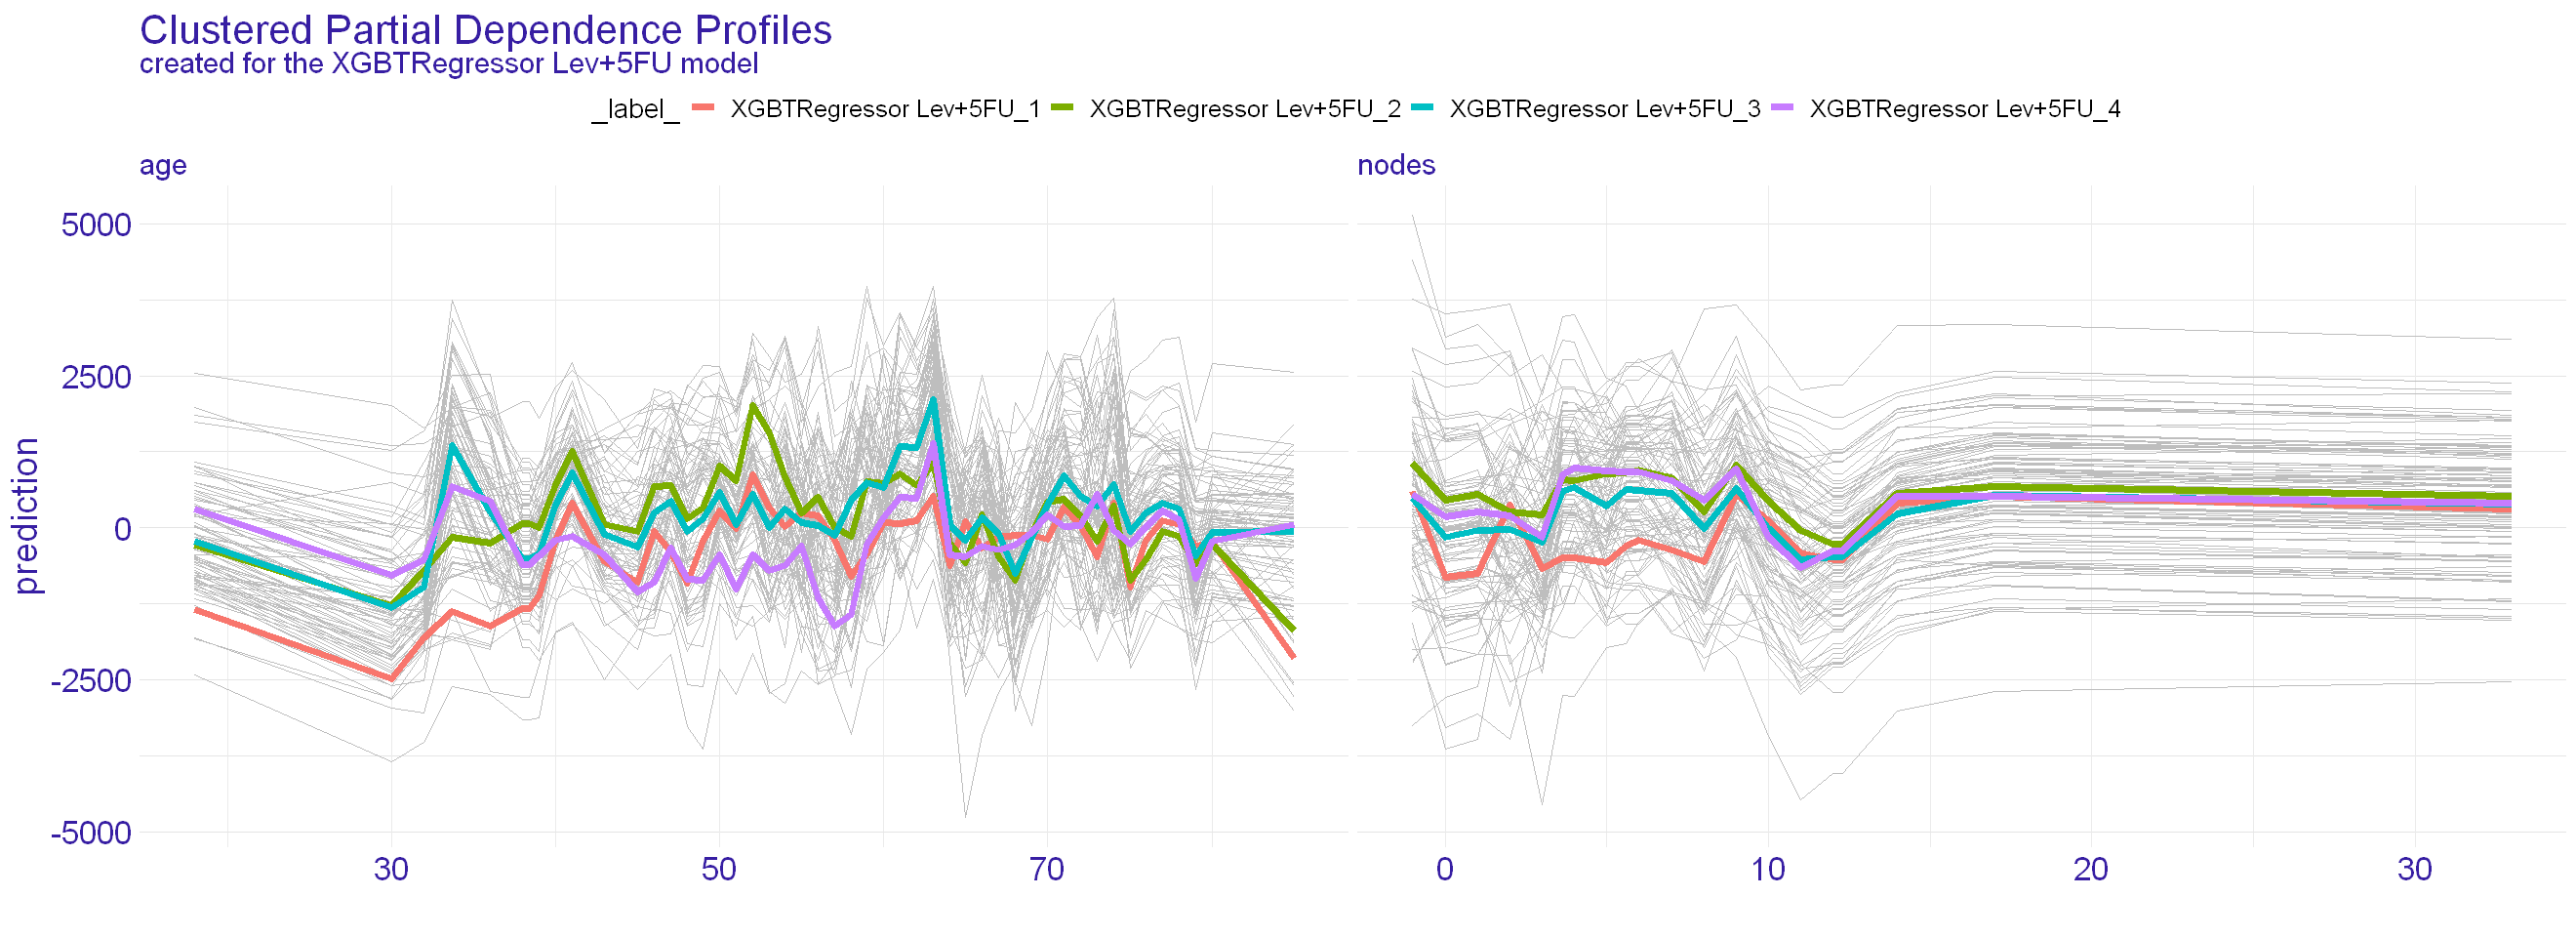

In [14]:
plot_grouped_Lev5FU <- explainer_Lev5FU %>>% model_profile(explained_vars, groups = "extent") %>>% plot(geom="profiles") %>>%
    fix_plot(adjust_title_margin = TRUE) %>>% `+`(ggtitle("Clustered Partial Dependence Profiles")) %>>% `+`(
        theme(
            strip.text = element_text(size = 18),
            plot.title = element_text(size = 25)
        )
    )

plot_grouped_Lev5FU

In [15]:
ggsave("../images/04-UL-PDP-Grouped-Lev.png", plot_grouped_Lev, width = 6.67 * 2)
ggsave("../images/04-UL-PDP-Grouped-Lev5FU.png", plot_grouped_Lev5FU, width = 6.67 * 2)

Saving 13.3 x 6.67 in image

Saving 13.3 x 6.67 in image



### ALE

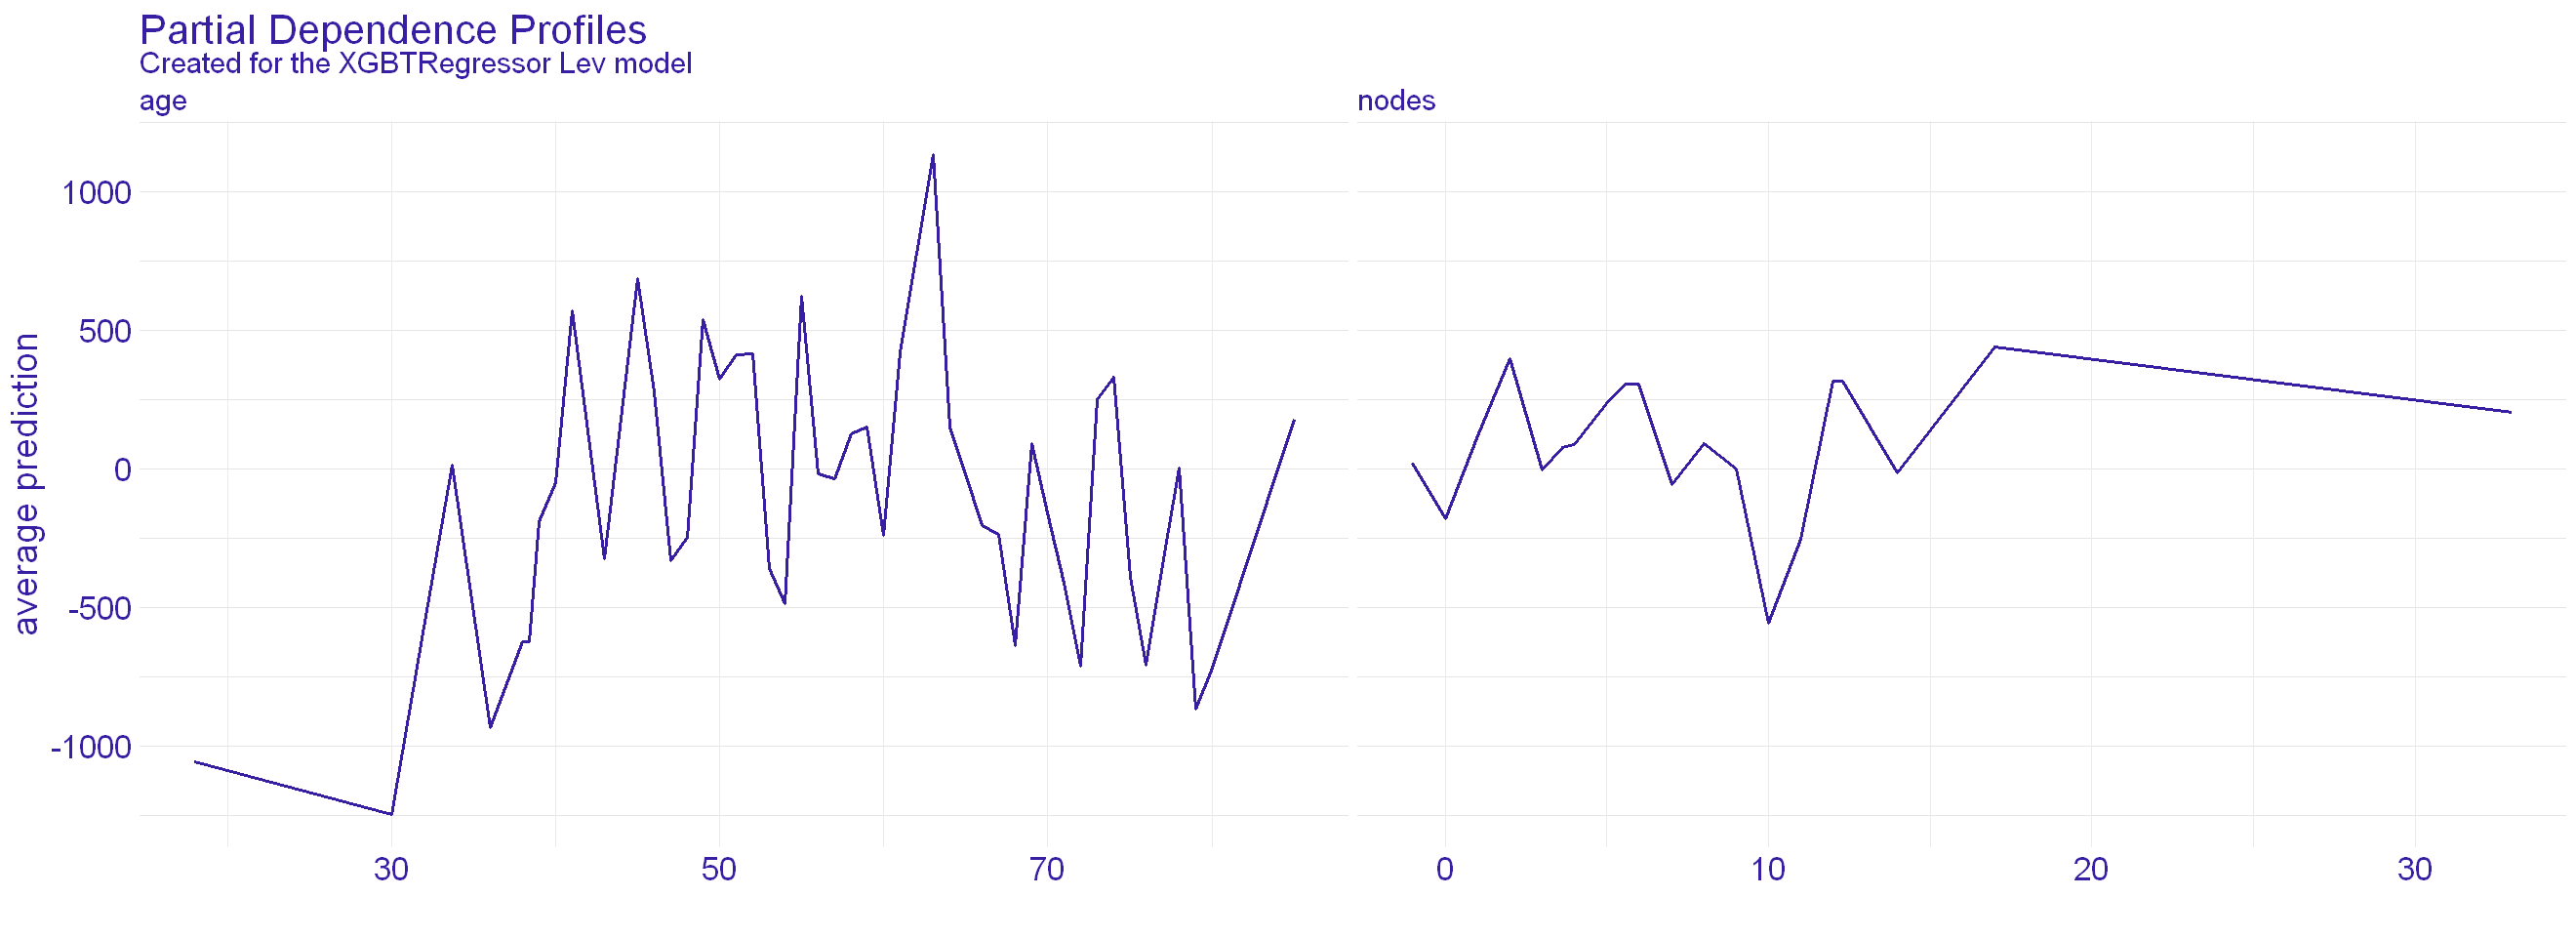

In [16]:
plot_pdp_avg_Lev <- explainer_Lev %>>% model_profile(explained_vars) %>>% plot() %>>%
    fix_plot() %>>% `+`(ggtitle("Partial Dependence Profiles")) %>>% `+`(
        theme(
            strip.text = element_text(size = 18),
            plot.title = element_text(size = 25)
        )
    )

plot_pdp_avg_Lev

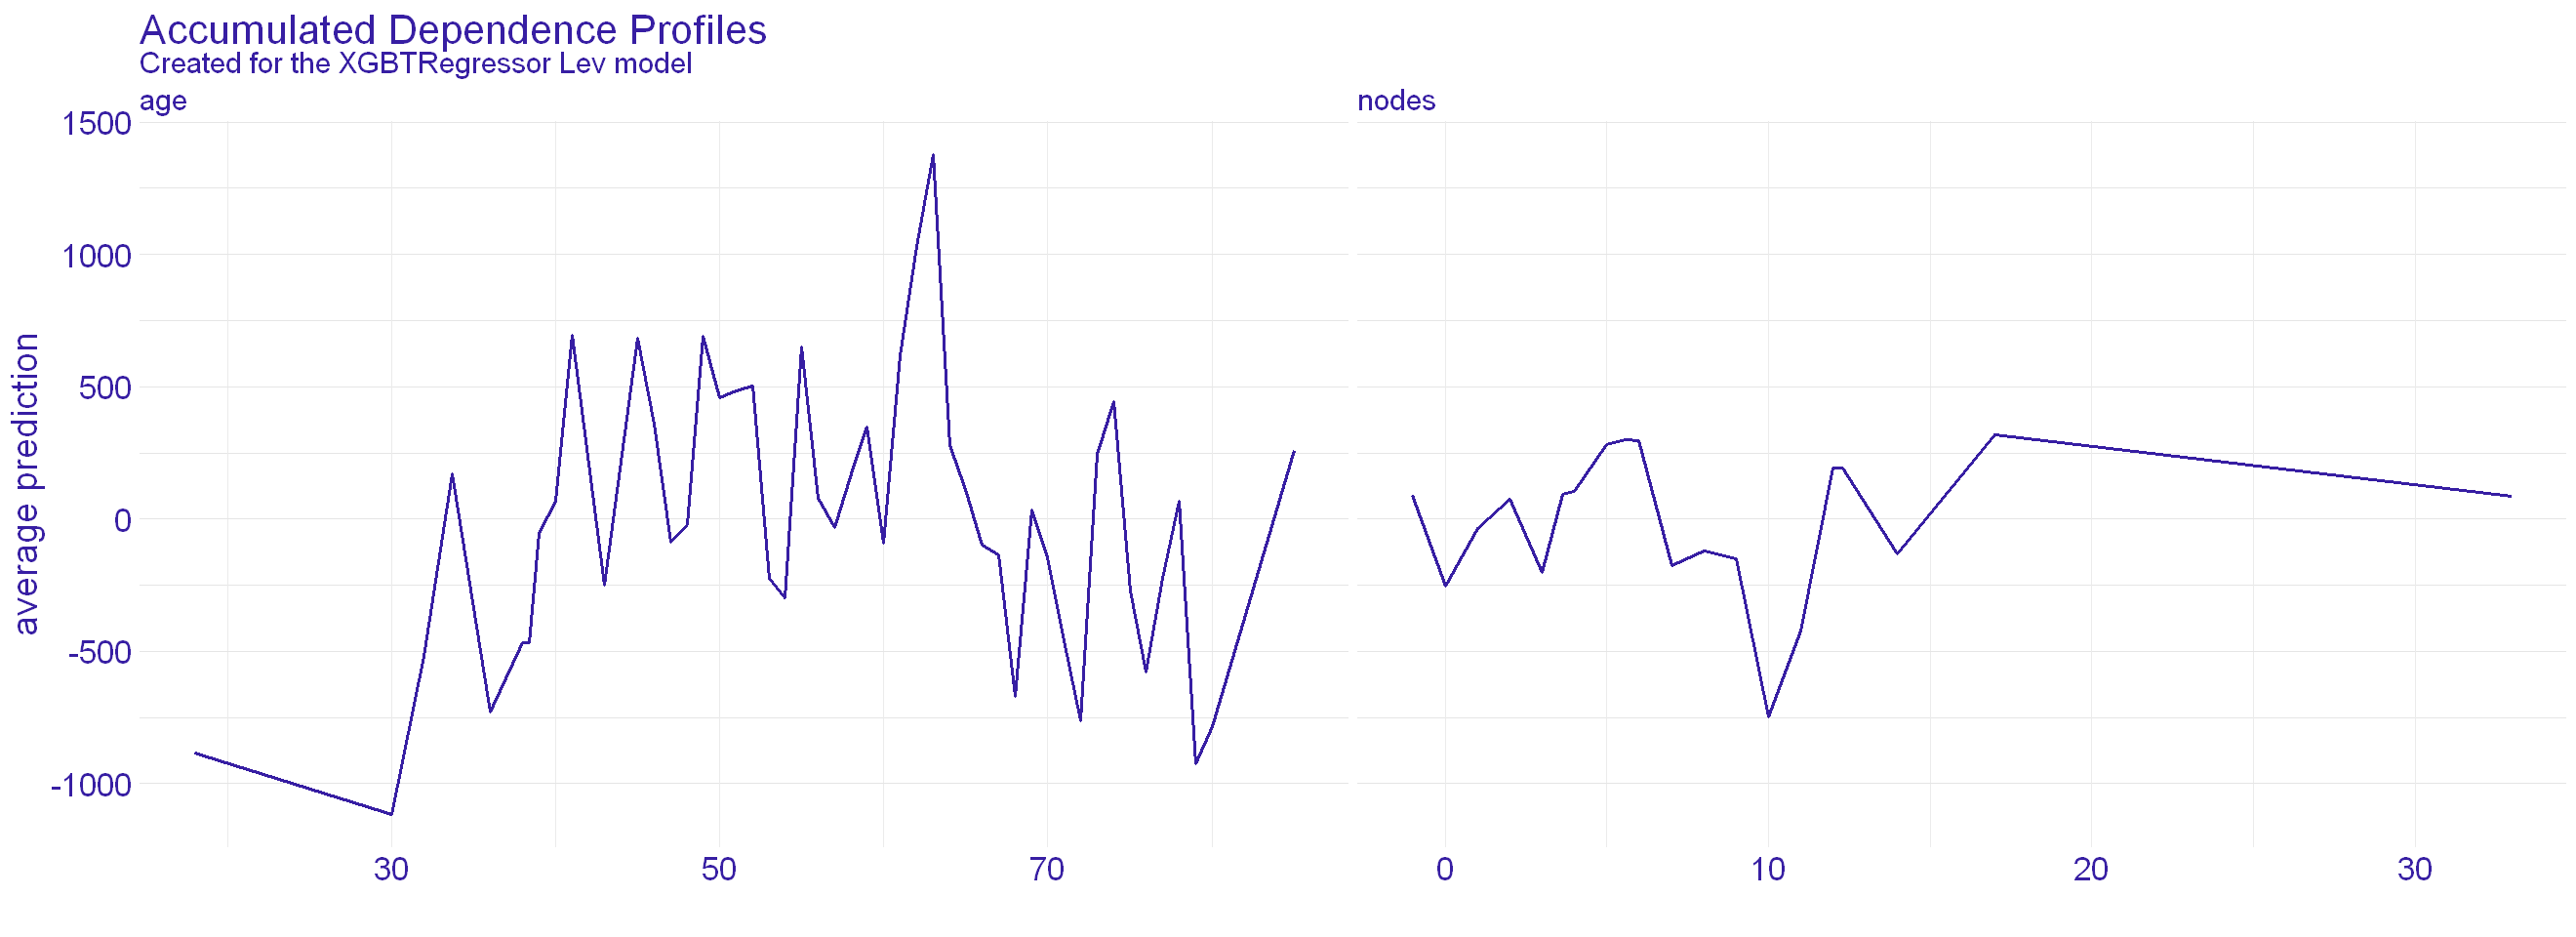

In [17]:
plot_pdp_ale_Lev <- explainer_Lev %>>% model_profile(explained_vars, type = "accumulated") %>>% plot() %>>%
    fix_plot() %>>% `+`(ggtitle("Accumulated Dependence Profiles")) %>>% `+`(
        theme(
            strip.text = element_text(size = 18),
            plot.title = element_text(size = 25)
        )
    )

plot_pdp_ale_Lev

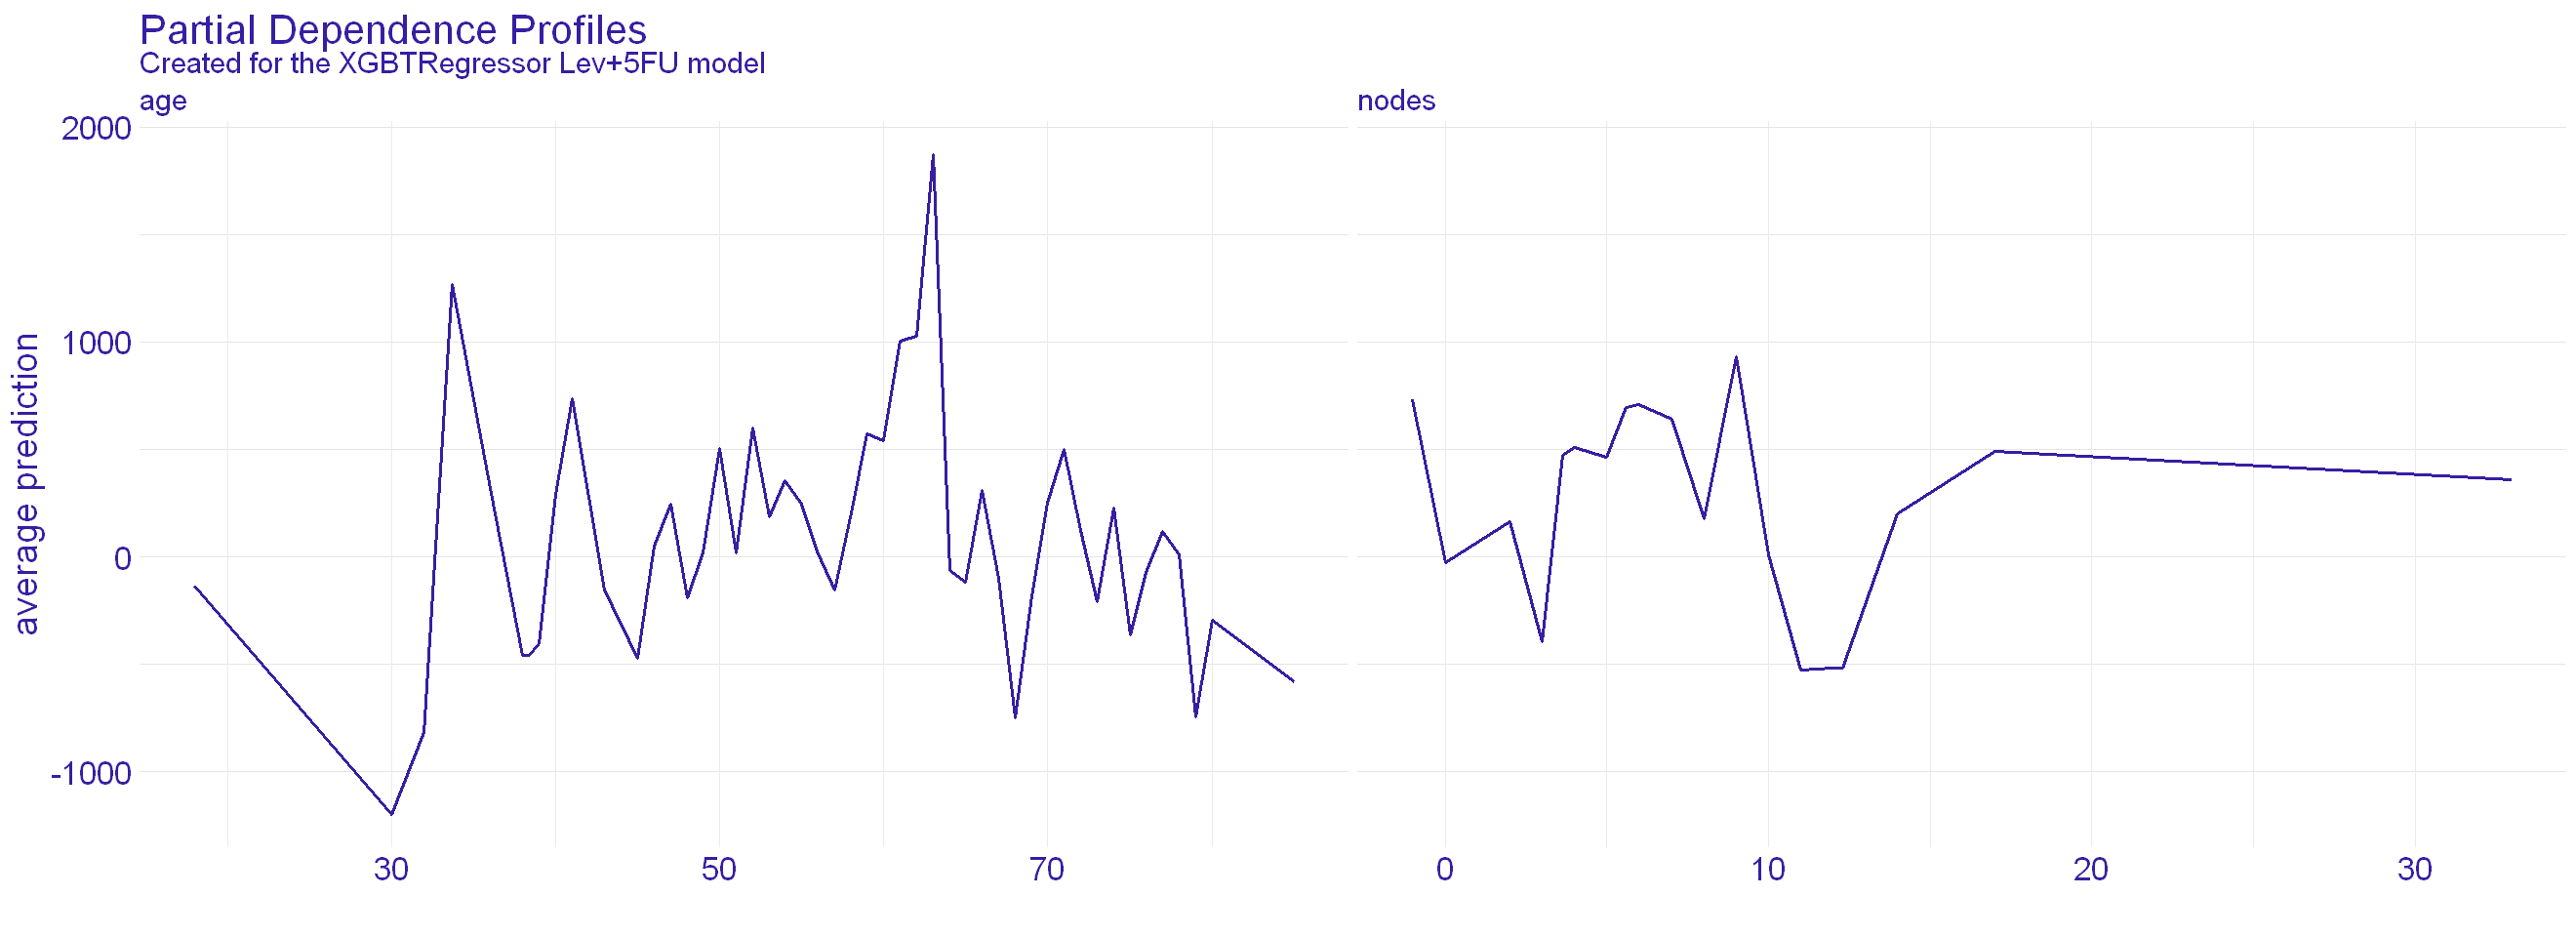

In [18]:
plot_pdp_avg_Lev5FU <- explainer_Lev5FU %>>% model_profile(explained_vars) %>>% plot() %>>%
    fix_plot() %>>% `+`(ggtitle("Partial Dependence Profiles")) %>>% `+`(
        theme(
            strip.text = element_text(size = 18),
            plot.title = element_text(size = 25)
        )
    )

plot_pdp_avg_Lev5FU

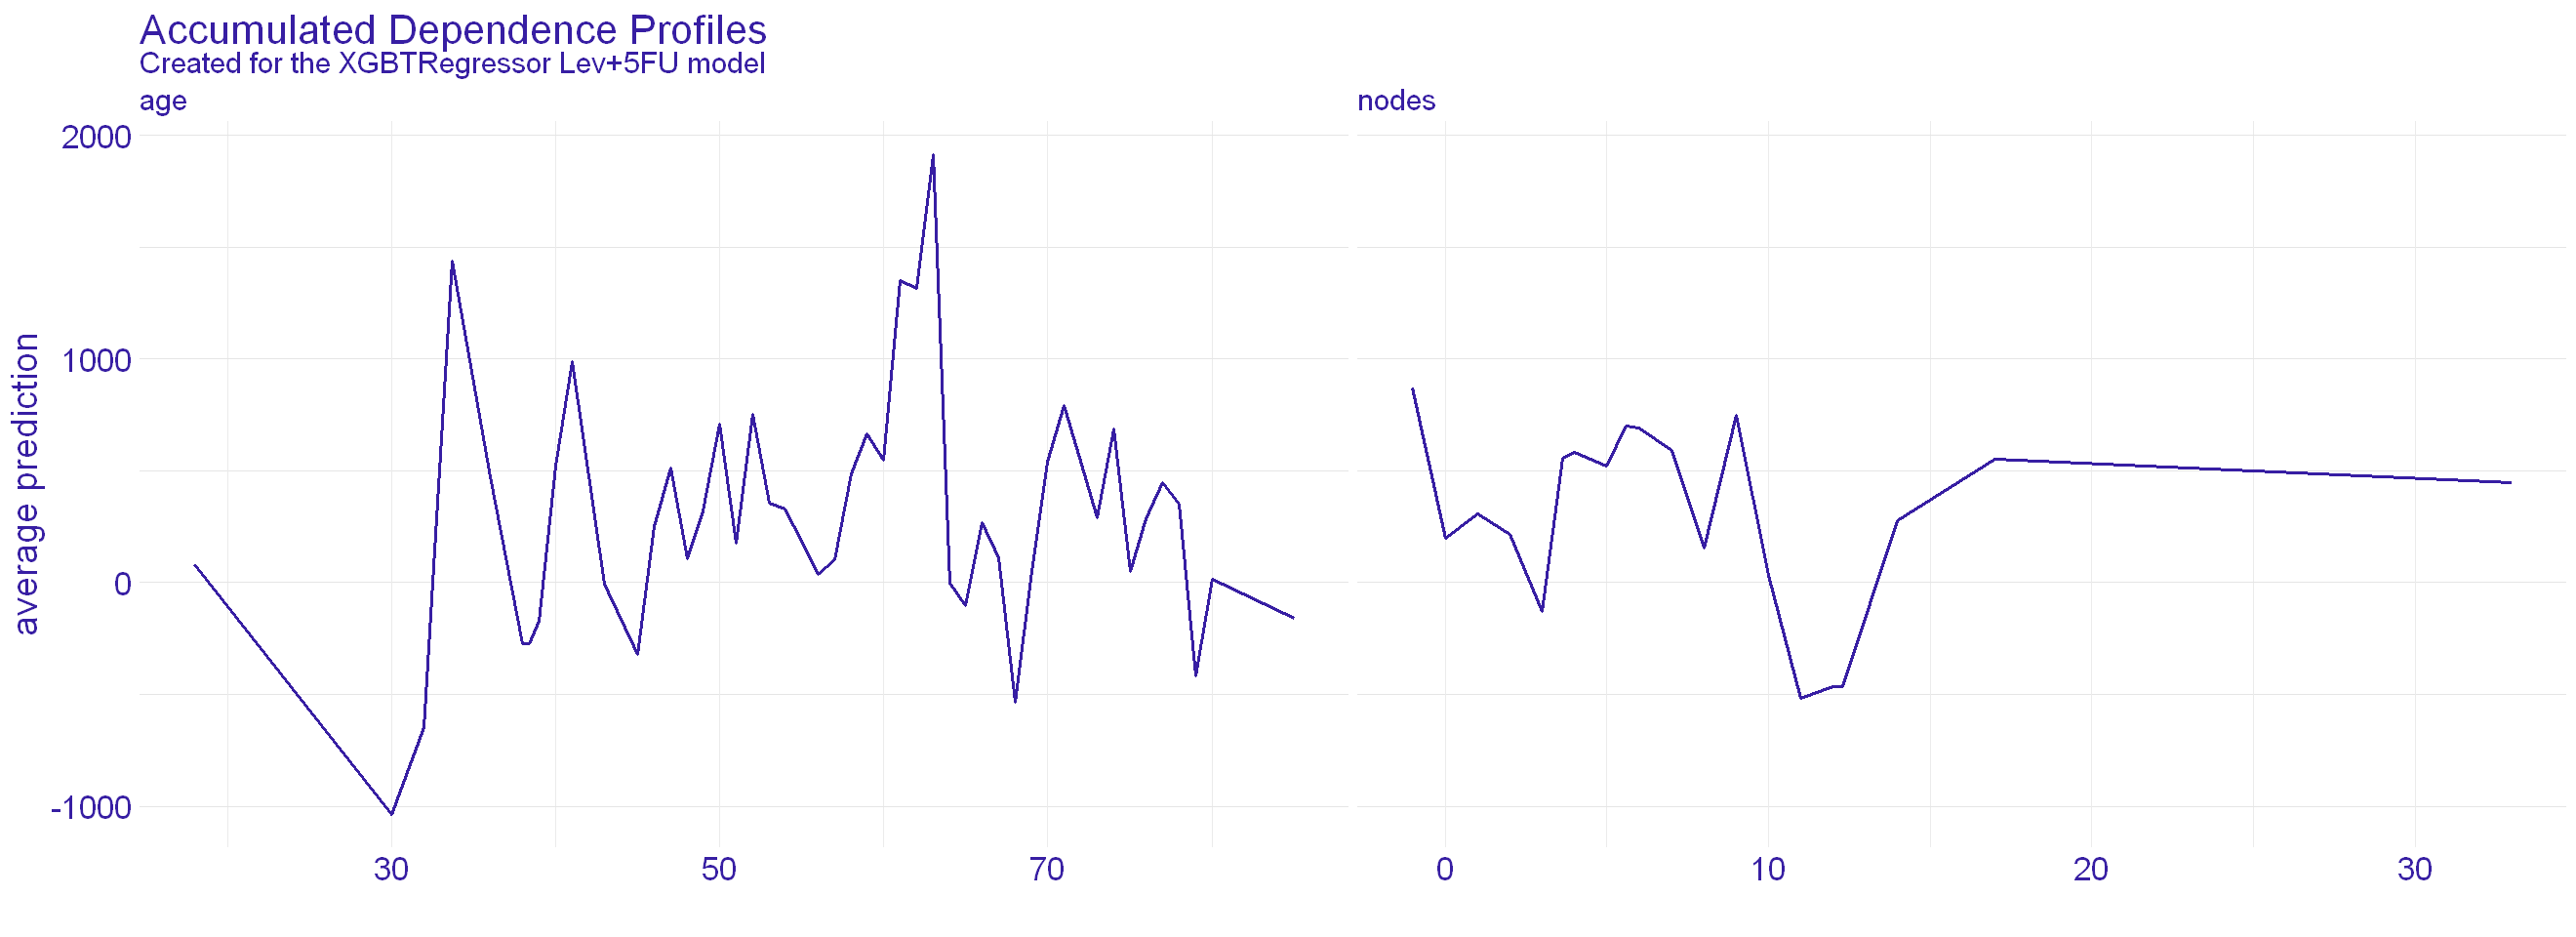

In [19]:
plot_pdp_ale_Lev5FU <- explainer_Lev5FU %>>% model_profile(explained_vars, type = "accumulated") %>>% plot() %>>%
    fix_plot() %>>% `+`(ggtitle("Accumulated Dependence Profiles")) %>>% `+`(
        theme(
            strip.text = element_text(size = 18),
            plot.title = element_text(size = 25)
        )
    )

plot_pdp_ale_Lev5FU

In [20]:
ggsave("../images/04-UL-PDP-Avg-Lev.png", plot_pdp_avg_Lev, width = 6.67 * 2)
ggsave("../images/04-UL-PDP-ALE-Lev.png", plot_pdp_ale_Lev, width = 6.67 * 2)
ggsave("../images/04-UL-PDP-Avg-Lev5FU.png", plot_pdp_avg_Lev5FU, width = 6.67 * 2)
ggsave("../images/04-UL-PDP-ALE-Lev5FU.png", plot_pdp_ale_Lev5FU, width = 6.67 * 2)

Saving 13.3 x 6.67 in image

Saving 13.3 x 6.67 in image

Saving 13.3 x 6.67 in image

Saving 13.3 x 6.67 in image

